# Micro Sim Video Model

## Imports

In [1]:
import os
import time
import gc
from itertools import chain
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass, asdict

from PIL import Image
from IPython import display
from IPython.display import Video
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import moviepy.editor as mpy
from base64 import b64encode

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import resize

from diffusers import UNet2DModel, DDIMScheduler, get_cosine_schedule_with_warmup

import wandb

In [2]:
wandb.login()

wandb: Currently logged in as: parameterized. Use `wandb login --relogin` to force relogin


True

## Data processing and display setup

In [3]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['image.cmap'] = 'binary'
sns.set_theme(style='darkgrid')

def display_video(path, loop=True):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display.display(display.HTML(f'''<video src="{
        data_url}" controls=true autoplay=true {
        "loop=true " if loop else ""}/>'''))

In [4]:
# close to actual mean/std
data_mean = np.full(3, .3)
data_std = np.full(3, .2)
print(data_mean, data_std)

# norm and inverse norm transformations
norm_t = transforms.Normalize(data_mean, data_std)
invnorm_t = transforms.Normalize(-data_mean / data_std, 1 / data_std)

tensor_to_img = lambda x: Image.fromarray(
    invnorm_t(x).clip(0, 1).movedim(-3, -1).detach().cpu()
    .multiply(255).type(torch.uint8).numpy())

[0.3 0.3 0.3] [0.2 0.2 0.2]


## Data and model configuration

In [5]:
@dataclass
class Config:
    # data
    frames_path: str = 'datasets/jams-germs/frames/Earthworm Under Microscope'
    frame_count: int = None
    frame_area: int = 910 * 512
    device: int = 'cuda'
    
    # model
    model_id: str = None
    model_type: str = 'FractalDN'
    embed_channels: int = 16 # divisible by 2
    sample_size: int = 32
    img_shape: tuple = None
    levels: int = 4
    hidden_channels: int = 16
    hidden_feats: int = 128
    steps_per_frame: tuple = (4, 8) # min, max inclusive
    
    # training
    load_pretrained: bool = False
    pretrained_path: str = 'models/FractalDN2_634566027'
    pool_size: int = 64
    batch_size: int = 16
    batch_frames: int = 4
    training_steps: int = int(2e4)
    lr: float = 1e-4
    warmup_steps: int = int(1e3)
    
    # training visualization/saving
    loss_every_n: int = 10
    display_every_n: int = 50
    video_every_n: int = int(2e3)
    save_every_n: int = int(1e3)
    
    # noise scheduler
    noise_scheduler_type: str = 'DDIM'
    train_timesteps: int = 1000
    inference_steps: int = 16
    inference_skip: int = 0
    
    # automatically set these
    def init(self):
        self.frame_count: int = len(os.listdir(self.frames_path))
        self.img_shape = (3, self.sample_size, self.sample_size)
        return self

cf = Config().init()
asdict(cf)

{'frames_path': 'datasets/jams-germs/frames/Earthworm Under Microscope',
 'frame_count': 3909,
 'frame_area': 465920,
 'device': 'cuda',
 'model_id': None,
 'model_type': 'FractalDN',
 'embed_channels': 16,
 'sample_size': 32,
 'img_shape': (3, 32, 32),
 'levels': 4,
 'hidden_channels': 16,
 'hidden_feats': 128,
 'steps_per_frame': (4, 8),
 'load_pretrained': False,
 'pretrained_path': 'models/FractalDN2_634566027',
 'pool_size': 64,
 'batch_size': 16,
 'batch_frames': 4,
 'training_steps': 20000,
 'lr': 0.0001,
 'warmup_steps': 1000,
 'loss_every_n': 10,
 'display_every_n': 50,
 'video_every_n': 2000,
 'save_every_n': 1000,
 'noise_scheduler_type': 'DDIM',
 'train_timesteps': 1000,
 'inference_steps': 16,
 'inference_skip': 0}

## Data sampling utilities

In [6]:
def get_batch(batch_size=None, start_frames=None, batch_frames=None):
    """Get batch of size (batch_size, cf.batch_frames, *cf.img_shape)"""
    comp = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(512), # images are 910x512
        transforms.Resize(cf.sample_size)
    ])
    
    if batch_size is None:
        batch_size = cf.batch_size
    if batch_frames is None:
        batch_frames = cf.batch_frames
    if start_frames is None:
        start_frames = np.random.randint(
            cf.frame_count - batch_frames + 1, size=(batch_size,))
    
    x0s = []
    ss = cf.sample_size
    for i in range(cf.levels):
        x0s.append(torch.empty(batch_size, batch_frames,
            3, ss, ss, device=cf.device))
        ss //= 2
    
    # load frame sequence at base resolution
    for i in range(batch_size):
        for j in range(batch_frames):
            img = Image.open(f'{cf.frames_path}/{start_frames[i] + j}.jpg')
            x0s[0][i, j] = norm_t(comp(img))
    
    # resize for all levels
    for i in range(1, cf.levels):
        # resize all frames by flattening onto batch dim
        x0_prev_timeflat = x0s[i - 1].view(-1, *x0s[i - 1].shape[-3:])
        x0s[i] = resize(x0_prev_timeflat, x0s[i].shape[-1]).view(x0s[i].shape)
    
    return x0s

def embed_ts(t):
    emb = t[..., None] * 2**torch.arange(cf.embed_channels // 2,
        device=cf.device) * torch.pi / 2
    return torch.cat([emb.sin(), emb.cos()], dim=-1)

In [7]:
class Pool():
    def __init__(self):
        """Create pool using cf config"""
        self.size = cf.pool_size
        self.is_first = torch.full((self.size,), True, device=cf.device)
        # low=1 so prev frame is valid
        self.start_frames = torch.randint(1,
            cf.frame_count - cf.batch_frames + 1, size=(self.size,))
        
        bx0s = get_batch(batch_size=1)
        self.last_bxt_hiddens = [torch.randn(self.size, cf.hidden_channels,
            *x0.shape[-2:], device=cf.device) for x0 in bx0s]
    
    def init(self, indices=None):
        """Re-initialize entire pool or at given indices"""
        if len(indices) == 0:
            return
        if indices is None:
            indices = torch.arange(self.size)
        
        self.is_first[indices] = True
        self.start_frames[indices] = torch.randint(1,
            cf.frame_count - cf.batch_frames + 1, size=(len(indices),))
        
        bx0s = get_batch(batch_size=1)
        for i, x0 in enumerate(bx0s):
            self.last_bxt_hiddens[i][indices] = torch.randn(
                len(indices), cf.hidden_channels, *x0.shape[-2:], device=cf.device)
    
    def sample(self, indices):
        # replace 1/4 of batch with new samples
        self.init(indices[:len(indices) // 4])
        # return self.start_frames[indices], self.memory[indices], self.is_first[indices]
        return (
            self.is_first[indices],
            self.start_frames[indices],
            [v[indices] for v in self.last_bxt_hiddens]
        )
    
    def replace(self, indices, last_bxt_hiddens, start_frames):
        self.is_first[indices] = False
        self.start_frames[indices] = start_frames + cf.batch_frames
        for i, h in enumerate(last_bxt_hiddens):
            self.last_bxt_hiddens[i][indices] = h.detach().clone()
        # re-init if end reached
        self.init(indices[start_frames >= cf.frame_count - cf.batch_frames * 2])

## Visualize data sampling

In [8]:
# (910*512)/(32*32) = 455 (full size patches)
def gen_trainset_video(path, fps=25):
    tp = Pool()
    perm = torch.arange(16)
    full_clip = torch.empty(16, 4 * 20, *cf.img_shape)
    for i in tqdm(range(full_clip.shape[1] // 4)):
        # first 1/4 gets replaced with new samples
        # start_frames, memory, is_first = tp.sample(perm)
        is_first, start_frames, last_bxt_hiddens = tp.sample(perm)
        x0s = get_batch(16, start_frames)
        full_clip[:, 4*i:4*(i+1)] = x0s[0]
        tp.replace(perm, last_bxt_hiddens, start_frames)
    
    def make_frame(frame_state):
        if frame_state['first_frame']:
            frame_state['first_frame'] = False
            return np.zeros((512, 512, 3), dtype=np.int8)
        
        i = frame_state['i']
        frame = torchvision.utils.make_grid(invnorm_t(full_clip[:, i]), nrow=4)
        frame_state['i'] = min(i + 1, full_clip.shape[1])
        frame = resize(frame, 512).permute(1, 2, 0)
        return frame.clip(0, 1).multiply(255).int().cpu().numpy()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    frame_state = {'i': 0, 'first_frame': True}
    clip = mpy.VideoClip(lambda t: make_frame(frame_state),
                         duration=full_clip.shape[1] / fps)
    clip.write_videofile(path, fps=fps)
    return clip

clip = gen_trainset_video('output/train_set.mp4')
display_video('output/train_set.mp4', loop=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:09<00:00,  2.09it/s]


Moviepy - Building video output/train_set.mp4.
Moviepy - Writing video output/train_set.mp4



Moviepy - Done !
Moviepy - video ready output/train_set.mp4


## Define model

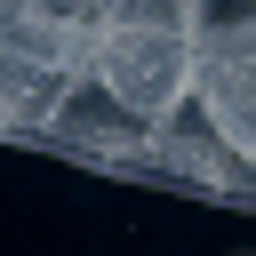

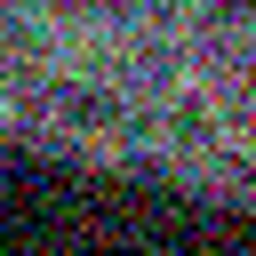

In [9]:
class LayerNorm(nn.Module):
    def forward(self, x):
        var, mean = torch.var_mean(x, dim=1,
            unbiased=False, keepdim=True)
        eps = 1e-5
        return (x - mean) * (var + eps).rsqrt()

class FractalDN(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Conv2d(
            (3 * 2 + cf.hidden_channels * 2) * 3, cf.hidden_feats, 3,
            padding=1, padding_mode='replicate'
        )
        self.l2 = nn.Conv2d(
            cf.hidden_feats, 3 + cf.hidden_channels, 1
        )
        
        self.scale_shift_l1 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(cf.embed_channels, cf.hidden_feats * 2)
        )
        self.scale_shift_l2 = nn.Sequential(
            nn.SiLU(),
            nn.Linear(cf.embed_channels, (3 + cf.hidden_channels) * 2)
        )
        
        self.layer_norm = LayerNorm()
        
        nn.init.zeros_(self.l2.weight)
        nn.init.zeros_(self.l2.bias)
    
    def forward(self, x_levels, timestep):
        """
        Evaluate the model
        
        Args:
            x_levels: List of image tensors with decreasing
                resolution in the concatenated form:
                [x_t, hidden_channels, x_t_prev, hidden_channels_prev]
            timestep: Long tensor of timesteps for each item in batch
        
        Returns:
            List of concatenated predictions for
                [x_t_noise, hidden_channels]
        """
        preds = []
        btes = embed_ts(timestep / cf.train_timesteps)
        ss_l1 = self.scale_shift_l1(btes)
        ss_l2 = self.scale_shift_l2(btes)
        for i, x in enumerate(x_levels):
            # higher res, lower res
            hr = x if i == 0 else resize(x_levels[i - 1], x.shape[-1])
            lr = x if i == len(x_levels) - 1 else resize(
                x_levels[i + 1], x.shape[-1]
            )
            xin = torch.cat([hr, x, lr], dim=1)
            
            h = self.l1(xin).relu()
            h = self.layer_norm(h) * ss_l1[:, :cf.hidden_feats, None, None]
            h = h + ss_l1[:, cf.hidden_feats:, None, None]
            
            h = self.l2(h)
            h = self.layer_norm(h) * ss_l2[:, :3 + cf.hidden_channels, None, None]
            py = h + ss_l2[:, 3 + cf.hidden_channels:, None, None]
            
            preds.append(x[:, :3 + cf.hidden_channels] + py)
        
        return preds

model = FractalDN().to(cf.device)

noise_scheduler = DDIMScheduler(num_train_timesteps=cf.train_timesteps)
noise_scheduler.set_timesteps(num_inference_steps=cf.inference_steps)

opt = torch.optim.AdamW(model.parameters(), lr=cf.lr)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=opt,
    num_warmup_steps=cf.warmup_steps,
    num_training_steps=cf.training_steps
)
loss_fn = nn.MSELoss()
losses = []

pool = Pool()

bx0s = get_batch(1)
bts = torch.rand(1, device=cf.device)
xt_timesteps = torch.tensor(
    [cf.train_timesteps // 4], dtype=torch.long, device=cf.device
)
# btes = embed_ts(bts)
is_first, start_frames, bxt_hidden = pool.sample(torch.arange(1))
xt_levels = [
    torch.cat([bx0[:, 0], bxth, bx0[:, 0], bxth], dim=1)
    for bx0, bxth in zip(bx0s, bxt_hidden)
]
noise_hidden_preds = model(xt_levels, xt_timesteps)
display.display(tensor_to_img(noise_hidden_preds[0][0, :3]).resize((256, 256)))

noise = torch.randn_like(xt_levels[0][:, :3])
noisy_image = noise_scheduler.add_noise(xt_levels[0][:, :3], noise, xt_timesteps)
display.display(tensor_to_img(noisy_image[0]).resize((256, 256)))

## Sampling

In [10]:
def get_pred_x0(x_t, t, pred_noise):
    alpha_prod_t = noise_scheduler.alphas_cumprod[t]
    beta_prod_t = 1 - alpha_prod_t
    return (x_t - beta_prod_t**.5 * pred_noise) / alpha_prod_t**.5

def gen_video(path, duration=2, fps=25, show_diffusion=False, memory_noise_level=0):
    tqdm._instances.clear()
    _training = model.training
    model.eval()
    
    def make_frame(frame_state):
        if frame_state['first_frame']:
            frame_state['first_frame'] = False
            return np.zeros((512, 512, 3), dtype=np.int8)
        
        with torch.no_grad():
            frame_imgs = torch.empty(4, 4, *cf.img_shape, device=cf.device)
            vis_id = 0
            
            # initialize rgbs for frame
            vid_batch_size = 4 if show_diffusion else 16
            ss = cf.sample_size
            bxt_rgbs = [torch.randn(vid_batch_size, 3, ss, ss, device=cf.device)]
            for i in range(1, cf.levels):
                ss //= 2
                bxt_rgbs.append(resize(bxt_rgbs[-1], ss))
            
            # load prev x0 if not first frame
            if frame_state.get('prev_x0') is not None:
                prev_x0 = frame_state['prev_x0']
            else:
                prev_x0 = [
                    torch.randn(
                        vid_batch_size, 3, *rgb.shape[-2:],
                        device=cf.device
                    ) for rgb in bxt_rgbs
                ]
            
            # load prev hiddens if not first frame
            if frame_state.get('bxt_hiddens') is not None:
                last_bxt_hiddens = frame_state['bxt_hiddens']
            else:
                last_bxt_hiddens = [
                    torch.randn(
                        vid_batch_size, cf.hidden_channels, *rgb.shape[-2:],
                        device=cf.device
                    ) for rgb in bxt_rgbs
                ]
            
            # reverse diffusion steps
            timesteps = noise_scheduler.timesteps[cf.inference_skip:]
            num_ts = len(timesteps)
            for i, t in enumerate(timesteps):
                memory_noise_t = timesteps[
                    int((num_ts - 1) * np.clip(1 - memory_noise_level, 0, 1))
                ]
                
                prev_x0_noised = [
                    noise_scheduler.add_noise(
                        px0, torch.randn_like(px0), memory_noise_t
                    ) for px0 in prev_x0
                ]
                prev_hiddens_noised = [
                    noise_scheduler.add_noise(
                        lbh, torch.randn_like(lbh), memory_noise_t
                    ) for lbh in last_bxt_hiddens
                ]
                
                bts = torch.full(
                    (vid_batch_size,), t, dtype=torch.long, device=cf.device
                )
                
                # randomize hiddens every diffusion step
                bxt_hiddens = [
                    torch.randn(
                        vid_batch_size, cf.hidden_channels, *rgb.shape[-2:],
                        device=cf.device
                    ) for rgb in bxt_rgbs
                ]
                
                for _ in range(cf.steps_per_frame[1]): # do max steps
                    x_levels = [
                        torch.cat([bxt_rgb, bxt_hidden, prev_x0_n, prev_hidden_n], dim=1)
                        for bxt_rgb, bxt_hidden, prev_x0_n, prev_hidden_n
                        in zip(bxt_rgbs, bxt_hiddens, prev_x0_noised, prev_hiddens_noised)
                    ]
                    
                    noise_hidden_preds = model(x_levels, bts)
                    # only update hidden channels
                    bxt_hiddens = [
                        nhp[:, 3:3 + cf.hidden_channels]
                        for nhp in noise_hidden_preds
                    ]
                
                if show_diffusion:
                    # show 4 of the diffusion steps
                    if i / (num_ts - 1) >= (vis_id + 1) / 4 or i == num_ts - 1:
                        pred_x0 = get_pred_x0(
                            bxt_rgbs[0][:, :3], t, noise_hidden_preds[0][:, :3]
                        )
                        frame_imgs[:, vis_id] = invnorm_t(pred_x0)
                        vis_id += 1
                elif i == num_ts - 1:
                    frame_imgs = invnorm_t(bxt_rgbs[0][:, :3]).view(4, 4, *cf.img_shape)
                
                # reverse diffusion step
                next_rgbs = []
                for bxt_rgb, nhp in zip(bxt_rgbs, noise_hidden_preds):
                    next_rgbs.append(
                        noise_scheduler.step(
                            nhp[:, :3], t, bxt_rgb
                        )['prev_sample']
                    )
                
                bxt_rgbs = next_rgbs
            
            frame_state['prev_x0'] = bxt_rgbs
            # use frame-persistent hiddens from final predicted x0
            frame_state['bxt_hiddens'] = bxt_hiddens
            
            frame = torchvision.utils.make_grid(
                frame_imgs.view(-1, *frame_imgs.shape[2:]), nrow=4
            )
            frame = resize(frame, 512).permute(1, 2, 0)
            return frame.clip(0, 1).multiply(255).int().cpu().numpy()
    
    if _training:
        model.train()
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    frame_state = {
        'first_frame': True
    }
    clip = mpy.VideoClip(lambda t: make_frame(frame_state), duration=duration)
    clip.write_videofile(path, fps=fps)    
    return clip

## Training

Model ID: 733880453
20,000 / 20,000
8h15m - eta 1s
lr: 0.00000000
loss: 0.00840225


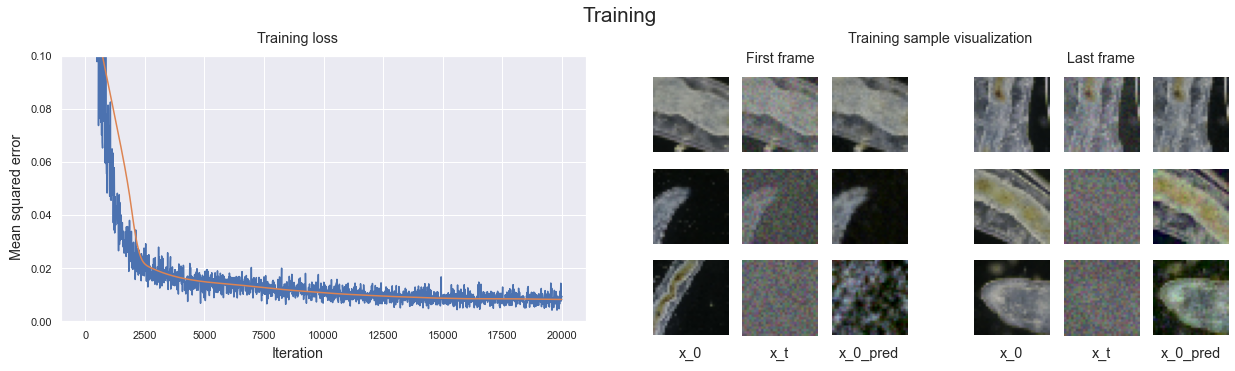

Moviepy - Building video models/FractalDN2_733880453/videos/step_20000.mp4.
Moviepy - Writing video models/FractalDN2_733880453/videos/step_20000.mp4



Moviepy - Done !
Moviepy - video ready models/FractalDN2_733880453/videos/step_20000.mp4
Generated video
Saved to models/FractalDN2_733880453


train/loss,█▄▃▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/loss,0.00928
train/step,20000


In [11]:
def time_to_s(t):
    h = int(t / 3600)
    m = int(t / 60) % 60
    s = int(t) % 60
    time_str = f'{h}h' if t >= 3600 else ''
    time_str += f'{m}m' if t >= 60 and m != 0 else ''
    time_str += f'{s}s' if t < 3600 and s != 0 else ''
    return time_str

def train():
    cf.model_id = f'{np.random.randint(1e9):09d}'
    model_path = f'models/FractalDN2_{cf.model_id}'
    
    model.train()
    
    run = wandb.init(
        # mode='disabled',
        project='FractalDN',
        config=asdict(cf),
        save_code=True
    )
    wandb.define_metric('train/step')
    wandb.define_metric('train/*', step_metric='train/step')
    
    with run:
        print('Training...')
        train_st = time.time()
        
        bt0 = torch.zeros(cf.batch_size, dtype=torch.long, device=cf.device)
        
        for i in range(cf.training_steps):
            perm = torch.randperm(pool.size)[:cf.batch_size]
            is_first, start_frames, last_bxt_hiddens = pool.sample(perm)
            
            bx0s = get_batch(cf.batch_size, start_frames)
            prev_x0s = [v[:, 0] for v in get_batch(cf.batch_size, start_frames - 1, 1)]
            for px0 in prev_x0s:
                px0[is_first] = torch.randn_like(px0[is_first])
            
            bts = torch.randint(
                noise_scheduler.num_train_timesteps,
                size=(cf.batch_size, cf.batch_frames),
                dtype=torch.long, device=cf.device
            )
            memory_ts = torch.randint(
                noise_scheduler.num_train_timesteps,
                size=(cf.batch_size, cf.batch_frames),
                dtype=torch.long, device=cf.device
            )
            
            bns = [torch.rand_like(bx0) for bx0 in bx0s]
            
            bxt_rgbs = [
                noise_scheduler.add_noise(
                    bx0.view(-1, *bx0.shape[-3:]),
                    bn.view(-1, *bn.shape[-3:]),
                    bts.view(-1)
                ).view(bx0.shape).detach()
                for bx0, bn in zip(bx0s, bns)
            ]
            
            loss = 0
            for frame_id in range(cf.batch_frames):                
                # randomize hiddens every frame
                bxt_hiddens = [
                    torch.randn(
                        cf.batch_size, cf.hidden_channels, *x0.shape[-2:],
                        device=cf.device
                    ) for x0 in bx0s
                ]
                
                prev_x0_noised = [
                    noise_scheduler.add_noise(
                        px0, torch.randn_like(px0), memory_ts[:, frame_id]
                    ) for px0 in prev_x0s
                ]
                prev_hiddens_noised = [
                    noise_scheduler.add_noise(
                        lbh, torch.randn_like(lbh), memory_ts[:, frame_id]
                    ) for lbh in last_bxt_hiddens
                ]
                
                spf = np.random.randint(cf.steps_per_frame[0], cf.steps_per_frame[1] + 1)
                for _ in range(spf):
                    x_levels = [
                        torch.cat([
                            bxt_rgb[:, frame_id], bxt_hidden, prev_x0_n, prev_hidden_n
                        ], dim=1)
                        for bxt_rgb, bxt_hidden, prev_x0_n, prev_hidden_n
                        in zip(bxt_rgbs, bxt_hiddens, prev_x0_noised, prev_hiddens_noised)
                    ]
                    
                    noise_hidden_preds = model(x_levels, bts[:, frame_id])
                    # only update hidden channels
                    bxt_hiddens = [
                        nhp[:, 3:3 + cf.hidden_channels]
                        for nhp in noise_hidden_preds
                    ]
                
                if frame_id == 0:
                    first_preds = noise_hidden_preds
                
                target_noises = [bn[:, frame_id] for bn in bns]
                loss = loss + torch.cat([
                    loss_fn(nhp[:, :3], target_noise)[None]
                    for nhp, target_noise in
                    zip(noise_hidden_preds, target_noises)
                ], dim=0).mean()
                
                # compute frame-persistent hiddens using x0
                fp_bxt_hiddens = [
                    torch.randn(
                        cf.batch_size, cf.hidden_channels, *x0.shape[-2:],
                        device=cf.device
                    ) for x0 in bx0s
                ]
                for _ in range(spf):
                    fp_x_levels = [
                        torch.cat([
                            bx0[:, frame_id], fp_bxt_hidden, prev_x0_n, prev_hidden_n
                        ], dim=1)
                        for bx0, fp_bxt_hidden, prev_x0_n, prev_hidden_n
                        in zip(bx0s, fp_bxt_hiddens, prev_x0_noised, prev_hiddens_noised)
                    ]
                    fp_noise_hidden_preds = model(fp_x_levels, bt0)
                    fp_bxt_hiddens = [
                        nhp[:, 3:3 + cf.hidden_channels]
                        for nhp in fp_noise_hidden_preds
                    ]

                last_bxt_hiddens = fp_bxt_hiddens
            
            loss = loss / cf.batch_frames
            
            # opt step
            opt.zero_grad()
            loss.backward()
            opt.step()
            lr_scheduler.step()
            
            # update pool
            pool.replace(perm, last_bxt_hiddens, start_frames) # detaches in fn
            
            # plot
            if (i + 1) % cf.loss_every_n == 0:
                losses.append(loss.item())
                wandb.log({
                    'train/step': i + 1,
                    'train/loss': loss.item()
                })
            
            if (i + 1) % cf.display_every_n == 0:
                display.clear_output(wait=True)
                print(f'Model ID: {cf.model_id}')
                print(f'{i + 1 :,} / {cf.training_steps:,}')
                time_passed = time.time() - train_st
                eta = time_passed * (cf.training_steps - i) / max(i, 1)
                print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
                print(f'lr: {opt.state_dict()["param_groups"][0]["lr"]:.8f}')
                recent_avg_loss = np.mean(losses[-100:])
                print(f'loss: {recent_avg_loss:.8f}')
                
                fig = plt.figure(constrained_layout=True, figsize=(5 * 3.4, 5))
                fig.suptitle('Training', fontsize='xx-large')
                loss_fig, vis_fig = fig.subfigures(1, 2, wspace=.1)
                
                loss_fig.suptitle('Training loss')
                loss_fig.supxlabel('Iteration')
                loss_fig.supylabel('Mean squared error')
                
                vis_fig.suptitle('Training sample visualization')
                
                ax = loss_fig.gca()
                loss_x = np.arange(len(losses)) * cf.loss_every_n
                loss_lowess = lowess(losses, loss_x, frac=.2)
                sns.lineplot(loss_x, losses, ax=ax)
                sns.lineplot(loss_lowess[:, 0], loss_lowess[:, 1])
                if len(losses) > 0:
                    plt.ylim(0, max(recent_avg_loss * 1.5, .1))
                
                vis_first, vis_last = vis_fig.subfigures(1, 2, wspace=.1)
                vis_first.suptitle('First frame')
                vis_last.suptitle('Last frame')
                
                last_preds = noise_hidden_preds
                for vis in [vis_first, vis_last]:                
                    vis_col_figs = vis.subfigures(1, 3)
                    x0_axes, xt_axes, x0p_axes = [
                        v.subplots(3, 1) for v in vis_col_figs]
                    for f, label in zip(vis_col_figs, ['x_0', 'x_t', 'x_0_pred']):
                        f.supxlabel(label)
                    
                    if vis == vis_first:
                        vis_frame = 0
                        noise_hidden_preds = first_preds
                    else:
                        vis_frame = -1
                        noise_hidden_preds = last_preds
                    
                    # show random samples of low, mid, high ranges of t
                    t_sort = torch.argsort(bts[:, vis_frame])
                    for k in range(3):
                        row_id = t_sort[np.random.randint(
                            t_sort.shape[0] // 3 * k,
                            t_sort.shape[0] // 3 * (k + 1))]
                        
                        x0_axes[k].imshow(tensor_to_img(bx0s[0][row_id, vis_frame]))
                        x0_axes[k].axis('off')
                        
                        xt_rgb = bxt_rgbs[0][row_id, vis_frame]
                        xt_axes[k].imshow(tensor_to_img(xt_rgb))
                        xt_axes[k].axis('off')
                        
                        t = bts[row_id, vis_frame]
                        pred_x0 = get_pred_x0(xt_rgb, t, noise_hidden_preds[0][row_id, :3])
                        x0p_axes[k].imshow(tensor_to_img(pred_x0))
                        x0p_axes[k].axis('off')
                
                plt.show()
            
            if (i + 1) % cf.video_every_n == 0:
                clip = gen_video(f'{model_path}/videos/step_{i + 1}.mp4')
                print('Generated video')
            
            if (i + 1) % cf.save_every_n == 0 or i == cf.training_steps - 1:
                os.makedirs(model_path, exist_ok=True)
                torch.save(model, f'{model_path}/model.pt')
                print(f'Saved to {model_path}')


if cf.load_pretrained:
    cf.model_id = cf.pretrained_path.split('_')[-1]
    model = torch.load(f'{cf.pretrained_path}/model.pt')
    print(f'Loaded from {cf.pretrained_path}')
else:
    gc.collect()
    torch.cuda.empty_cache()
    tqdm._instances.clear()
    train()

## Sample from model

Moviepy - Building video output/FractalDN2_733880453.mp4.
Moviepy - Writing video output/FractalDN2_733880453.mp4



Moviepy - Done !
Moviepy - video ready output/FractalDN2_733880453.mp4
Generated 5 seconds in 1m28s


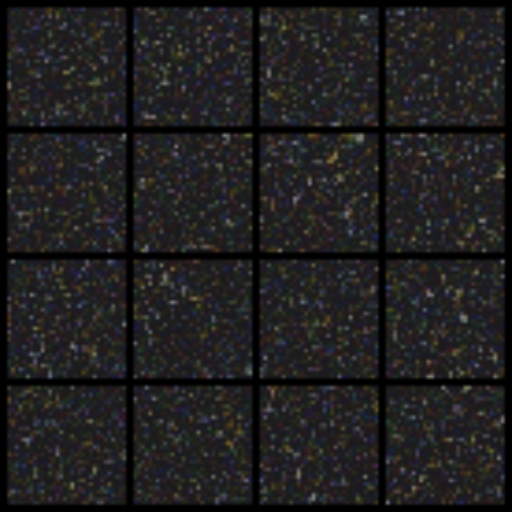

In [12]:
cf.inference_steps = 16
noise_scheduler.set_timesteps(num_inference_steps=cf.inference_steps)

clip_st = time.time()
clip_name = f'FractalDN2_{cf.model_id}'
clip_duration = 5
clip = gen_video(f'output/{clip_name}.mp4', duration=clip_duration, memory_noise_level=.1)
print(
    f"""Generated {clip_duration} second{
    "" if clip_duration == 1 else "s"} in {
    time_to_s(time.time() - clip_st)}"""
)
display_video(f'output/{clip_name}.mp4', loop=False)

display.display(Image.fromarray(
    clip.get_frame(2).astype(np.uint8)
).resize((512, 512)))